# Gradual Domain Adaptation

In this example, we explore how to use DaDiL for Gradual Domain Adaptation.

In [1]:
import os
import sys

sys.path.append('../')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [3]:
from pydil.torch_utils.measures import SupervisedDatasetMeasure
from pydil.torch_utils.measures import UnsupervisedDatasetMeasure
from pydil.dadil.labeled_dictionary import LabeledDictionary
from pydil.ipms.ot_ipms import JointWassersteinDistance
from pydil.toy_datasets.domain_adaptation.gda import gradual_da_toy_example

from pydil.ot_utils.pot_utils import emd
from pydil.ot_utils.pot_utils import unif
from pydil.ot_utils.sinkhorn import log_sinkhorn
from pydil.ot_utils.barycenters import wasserstein_barycenter

2023-07-19 13:13:46.221966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:13:46.418575: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 13:13:46.449534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 13:13:47.021872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [4]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

## Hyper-Parameters

- ```n_components```: Number of atoms in DaDiL
- ```labeled_intermediate_distributions```: If True, we use ground-truth labels in the intermediate distributions.
- ```n_samples```: Number of samples in intermediate domains
- ```angle_min```: minimum angle for intermediate domains
- ```angle_max```: maximum angle for intermediate domains
- ```b_min```: minimum translation for intermediate domains
- ```b_max```: maximum translation for intermediate domains

In [5]:
n_components = 3
labeled_intermediate_distributions = True
n_samples = 500
angle_min = 5
angle_max = 45
b_min = 0.5
b_max = 5

## Gradual Domain Adaptation

In gradual domain adaptation [Kumar et al., 2020], one has a labeled source domain $Q_{S}$ where a labeled sample $\{(\mathbf{x}_{i}^{(Q_{S})}, \mathbf{y}_{i}^{(Q_{S})})\}_{i=1}^{n}$ is available, and a target domain $Q_{T}$ where an unlabeled sample $\{\mathbf{x}_{j}^{(Q_{T})}\}_{j=1}^{m}$ is available. Besides these two domains, one has access to unlabeled intermediate domains,

$$Q_{t}, t \in (0, 1)$$

which interpolate the distributional shift between $Q_{S}$ and $Q_{T}$.

In this example we create a toy model for gradual DA, by defining $Q_{t} = L_{t,\sharp}Q_{0}$. We set $Q_{S}:=Q_{0}$ and $Q_{T} := Q_{1}$. The mapping $L_{t}$ is linear, that is,

$$L_{t}(\mathbf{x}) = A_{t}\mathbf{x} + b_{t}$$

where $A_{t}$ is a rotation matrix, defined by an angle $\theta_{t} \in (\theta_{min},\theta_{max})$ and $b_{t} \in (b_{min},b_{max})$ is a translation.

In [6]:
Xs, Ys, Xt, Yt, XT, YT = gradual_da_toy_example(n_samples,
                                                angle_min=angle_min,
                                                angle_max=angle_max,
                                                b_min=b_min,
                                                b_max=b_max)

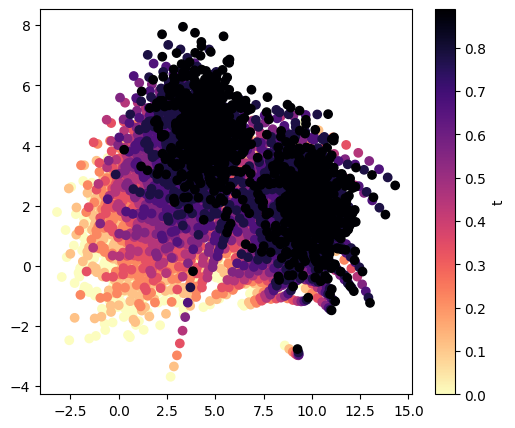

In [7]:
_Xt = torch.flatten(Xt, start_dim=0, end_dim=1)
c = torch.cat([torch.tensor([i / len(Xt)] * len(Xti)) for i, Xti in enumerate(Xt)])

fig = plt.figure(figsize=(6, 5))
sc = plt.scatter(_Xt[:, 0], _Xt[:, 1], c=c, cmap=plt.cm.magma_r)
cbar = fig.colorbar(sc)
cbar.set_label('t')

#for i, Xti in enumerate(Xt):
#    sca = plt.scatter(Xti[:, 0], Xti[:, 1], color=cmap(i / 9))

## Generating pseudo-labels

We propagate labels from $Q_{0}$ towards $Q_{T}$ by pseudo-labeling. Namely,

$$\pi^{(t_{0},t_{1})} = OT(\mathbf{X}^{(Q_{t_{1}})}, \mathbf{X}^{(Q_{t_{0}})})$$

$$\mathbf{y}^{(Q_{t_{1}})}_{i} = n_{t_{1}}\sum_{j=1}^{n_{t_{0}}}\pi^{(t_{0},t_{1})}_{ij}\mathbf{y}^{(t_{0})}_{j}$$

In [8]:
all_domains = [Xs] + [Xti for Xti in Xt] + [XT]
true_labels = [Ys] + [Yti for Yti in Yt] + [YT]
pseudo_labels = [Ys]

for Xti, Xtj, Ytj in zip(all_domains[:-1],
                         all_domains[1:],
                         true_labels[1:]):
    Yti = pseudo_labels[-1]
    
    uti = unif(len(Xti))
    utj = unif(len(Xtj))
    Cij = torch.cdist(Xti, Xtj, p=2) ** 2
    ot_plan = emd(uti, utj, Cij)
    # ot_plan = log_sinkhorn(uti, utj, Cij, reg_e=1e-3)
    _T = ot_plan / ot_plan.sum(dim=1)[:, None]
    _Ytj = _T @ Yti
    
    print("Accuracy: {}".format(accuracy_score(Ytj.argmax(dim=1), _Ytj.argmax(dim=1))))
    pseudo_labels.append(_Ytj)

Accuracy: 0.988
Accuracy: 0.99
Accuracy: 0.984
Accuracy: 0.984
Accuracy: 0.98
Accuracy: 0.976
Accuracy: 0.972
Accuracy: 0.968
Accuracy: 0.964
Accuracy: 0.964


In our experiments with DaDiL, we use the pseudo-labels in the intermediate and target domains.

In [9]:
Q = [
    SupervisedDatasetMeasure(
        features=Xs.numpy(),
        labels=Ys.argmax(dim=1).numpy(),
        stratify=True,
        batch_size=128,
        device='cpu'
    )
]

In [10]:
for Xti, Yti in zip(Xt, pseudo_labels[1:-1]):
    if labeled_intermediate_distributions:
        Q.append(
            SupervisedDatasetMeasure(
                features=Xti.numpy(),
                labels=Yti.argmax(dim=1).numpy(),
                stratify=True,
                batch_size=128,
                device='cpu'
            )
        )
    else:
        Q.append(
            UnsupervisedDatasetMeasure(
                features=Xti.numpy(),
                batch_size=128,
                device='cpu'
            )
        )

In [11]:
Q.append(
    SupervisedDatasetMeasure(
        features=XT.numpy(),
        labels=pseudo_labels[-1].argmax(dim=1).numpy(),
        stratify=True,
        batch_size=128,
        device='cpu'
    )
)

## Training DaDiL

In [12]:
loss_fn = JointWassersteinDistance()
dictionary = LabeledDictionary(XP=None,
                               YP=None,
                               A=None,
                               n_samples=256,
                               n_dim=2,
                               n_classes=2,
                               n_components=n_components,
                               weight_initialization='uniform',
                               n_distributions=len(Q),
                               loss_fn=loss_fn,
                               learning_rate_features=1e-1,
                               learning_rate_labels=None,
                               learning_rate_weights=None,
                               reg_e=0.0,
                               n_iter_barycenter=10,
                               n_iter_sinkhorn=20,
                               n_iter_emd=1000000,
                               domain_names=None,
                               grad_labels=True,
                               optimizer_name='adam',
                               balanced_sampling=True,
                               sampling_with_replacement=True,
                               barycenter_tol=1e-9,
                               barycenter_beta=None,
                               tensor_dtype=torch.float32,
                               track_atoms=False)
dictionary.fit(Q, n_iter_max=20, batches_per_it=20)

  0%|          | 0/20 [00:00<?, ?it/s]

It 0/20, Loss: 435.20719299316397


  0%|          | 0/20 [00:00<?, ?it/s]

It 1/20, Loss: 217.03334808349607


  0%|          | 0/20 [00:00<?, ?it/s]

It 2/20, Loss: 130.59758262634278


  0%|          | 0/20 [00:00<?, ?it/s]

It 3/20, Loss: 80.23803176879882


  0%|          | 0/20 [00:00<?, ?it/s]

It 4/20, Loss: 45.43593597412109


  0%|          | 0/20 [00:00<?, ?it/s]

It 5/20, Loss: 21.791208600997926


  0%|          | 0/20 [00:00<?, ?it/s]

It 6/20, Loss: 12.982618284225465


  0%|          | 0/20 [00:00<?, ?it/s]

It 7/20, Loss: 9.099245595932008


  0%|          | 0/20 [00:00<?, ?it/s]

It 8/20, Loss: 7.193619227409363


  0%|          | 0/20 [00:00<?, ?it/s]

It 9/20, Loss: 5.918166851997376


  0%|          | 0/20 [00:00<?, ?it/s]

It 10/20, Loss: 5.412089896202088


  0%|          | 0/20 [00:00<?, ?it/s]

It 11/20, Loss: 5.376271605491637


  0%|          | 0/20 [00:00<?, ?it/s]

It 12/20, Loss: 4.847303509712219


  0%|          | 0/20 [00:00<?, ?it/s]

It 13/20, Loss: 4.732090353965759


  0%|          | 0/20 [00:00<?, ?it/s]

It 14/20, Loss: 4.581428694725037


  0%|          | 0/20 [00:00<?, ?it/s]

It 15/20, Loss: 4.756525444984436


  0%|          | 0/20 [00:00<?, ?it/s]

It 16/20, Loss: 4.5645067453384405


  0%|          | 0/20 [00:00<?, ?it/s]

It 17/20, Loss: 4.624039292335509


  0%|          | 0/20 [00:00<?, ?it/s]

It 18/20, Loss: 4.693844294548034


  0%|          | 0/20 [00:00<?, ?it/s]

It 19/20, Loss: 4.5419997692108165


Next, we visualize the learned atoms. ```XP``` and ```YP``` correspond, each, to a tensor of shape ```(K, n, d)``` and ```(K, n, nc)```, where

- ```K``` is the number of components,
- ```n``` is the number of samples,
- ```d``` is the number of dimensions,
- ```nc``` is the number of classes.

### Visualizing loss

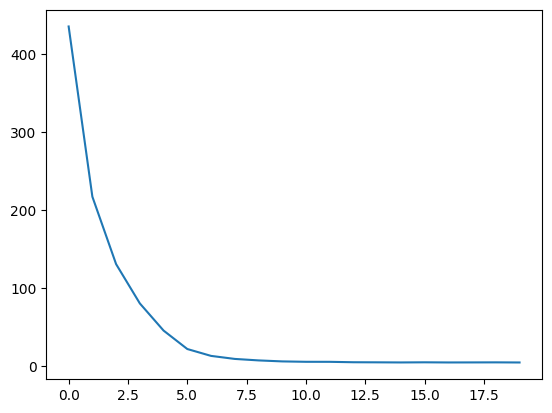

In [13]:
plt.plot(dictionary.history['loss'])

### Visualizing Atoms

In [14]:
XP, YP = dictionary.get_atoms()

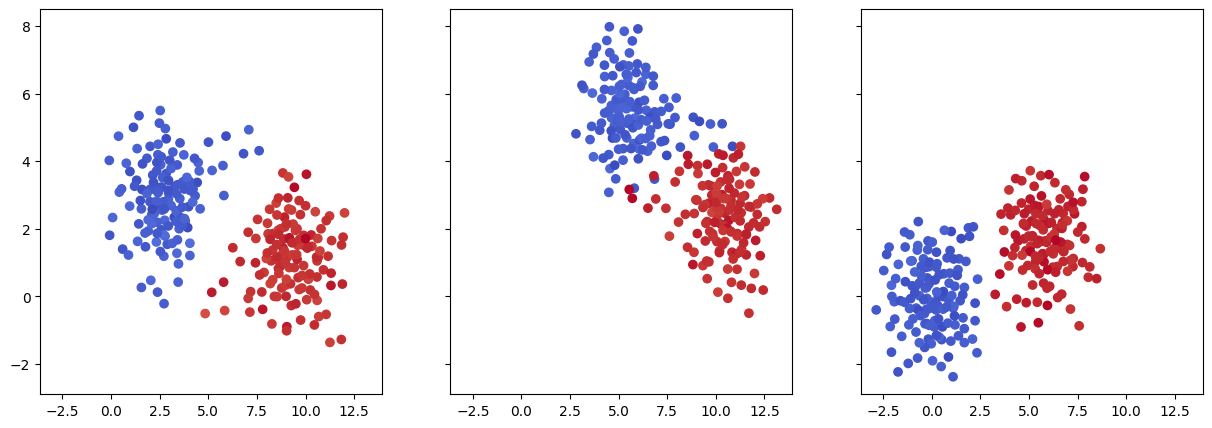

In [15]:
fig, axes = plt.subplots(1, n_components, figsize=(n_components * 5, 5), sharex=True, sharey=True)

for k in range(n_components):
    axes[k].scatter(XP[k, :, 0], XP[k, :, 1], c=YP[k, :, 1], cmap=plt.cm.coolwarm)

### Visualizing Learned weights

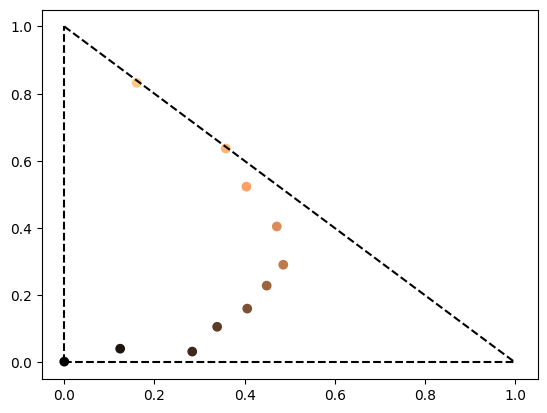

In [16]:
A = dictionary.get_weights()
t = np.linspace(0, 1, len(Q))

plt.scatter(A[:, 0], A[:, 1], c=t, cmap='copper')
plt.plot([0., 1.], [0., 0.], 'k--')
plt.plot([0., 0.], [0., 1.], 'k--')
plt.plot([0., 1.], [1., 0.], 'k--')

### Visualizing evolution of weights

In [17]:
dictionary_weight_history = []

for W in dictionary.history['weights']:
    tmp = []
    for l in range(len(Q)):
        wl = W[l, :]
        tmp.append(wl)
    tmp = torch.stack(tmp)
    dictionary_weight_history.append(tmp)

dictionary_weight_history = torch.stack(dictionary_weight_history)

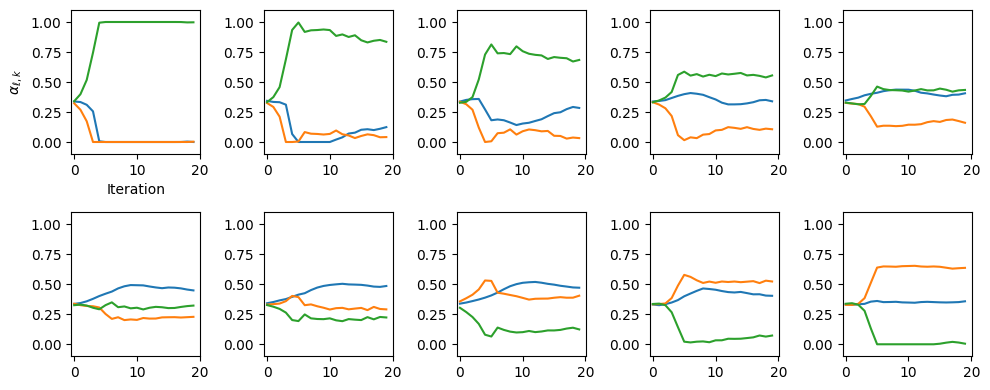

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    for k in range(n_components):
        ax.plot(dictionary_weight_history[:, i, k], label='Atom {}'.format(k + 1))
    # ax.set_title('{}'.format(names[i]))
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlim([-0.5, 20.1])
axes[0, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 0].set_xlabel('Iteration')
plt.tight_layout()

#### Animation

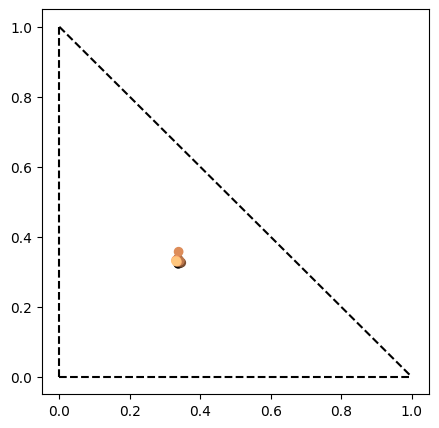

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

W0 = dictionary_weight_history[0, :, :]
ax.scatter(W0[:, 0], W0[:, 1], c=t, cmap='copper')
ax.plot([0., 1.], [0., 0.], 'k--')
ax.plot([0., 0.], [0., 1.], 'k--')
ax.plot([0., 1.], [1., 0.], 'k--')

def update(frame):
    # clear the axis each frame
    ax.clear()
    
    # replot things
    ax.scatter(frame[:, 0], frame[:, 1], c=t, cmap='copper')
    ax.plot([0., 1.], [0., 0.], 'k--')
    ax.plot([0., 0.], [0., 1.], 'k--')
    ax.plot([0., 1.], [1., 0.], 'k--')

anim = FuncAnimation(fig, update, frames=dictionary_weight_history, interval=300)

In [20]:
HTML(anim.to_jshtml())

### Reconstructing Labeled Domain Data

In [21]:
reconstructions = dictionary.reconstruct()

#### Source Domain Data

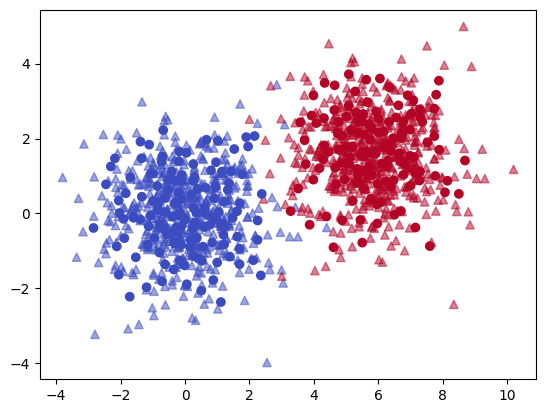

In [22]:
Xr, Yr = reconstructions[0]

plt.scatter(Xs[:, 0], Xs[:, 1], c=Ys.argmax(dim=1), cmap=plt.cm.coolwarm, alpha=0.5, marker='^')
plt.scatter(Xr[:, 0], Xr[:, 1], c=Yr.argmax(dim=1), cmap=plt.cm.coolwarm)

#### Target Domain Data

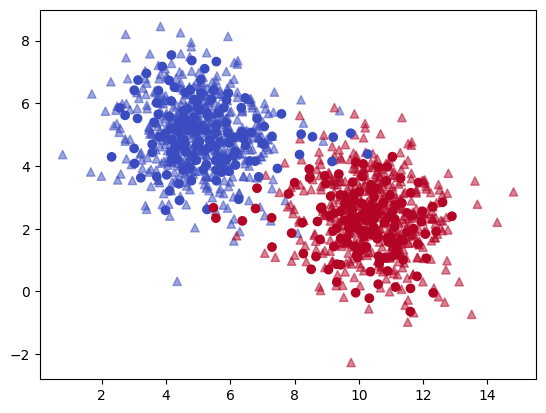

In [23]:
Xr, Yr = reconstructions[-1]

plt.scatter(XT[:, 0], XT[:, 1], c=YT.argmax(dim=1), cmap=plt.cm.coolwarm, alpha=0.5, marker='^')
plt.scatter(Xr[:, 0], Xr[:, 1], c=Yr.argmax(dim=1), cmap=plt.cm.coolwarm)

## References

[Kumar et al., 2020] Kumar, A., Ma, T., & Liang, P. (2020, November). Understanding self-training for gradual domain adaptation. In International Conference on Machine Learning (pp. 5468-5479). PMLR.